In [1]:
import numpy as np
import matplotlib.pyplot as plt


## C++ implementation of Glikonal-G
We provide a C++ implementation of Glikonal-G to show the performance of the algorithm.

We first define the elevation, wind, and initial position of the glider.
We also initialize the solutino in a small circle around the initial position of the glider

We then write the elevation, the wind, and the initialized solution on three separate files so that the c++ program can read them.

In [13]:
def point_source_HJB_uniform_solver(init_pos,init_altitude,radius,H,W,hy,hx,velocity_func):
    """
    Solves exactly the HJB equation for GRRP with a point source at pos_seed and a uniform velocity field. Uniform means that the velocity velocity_func(pos,a) is constant in pos, but not necessarily in a.
    The solution is computed on a grid of size HxW nodes, with x and y spacing respectively hx and hy.
    In this case the solution is easy because the characteristics are just straight lines, so the solution at x is just the distance between x and the source, divided by the velocity in direction x-source.
    
    Args:
    pos_seed: tuple of two integers, representing the position of the source.
    radius: float, the radius  around pos_seed where the solution is computed.
    H: integer, number of rows in the grid.
    W: integer, number of columns in the grid.
    hx: float, the x-spacing of the grid.
    hy: float, the y-spacing of the grid.
    velocity_func: function, representing the velocity field of the graph as a function of the position and the direction. It is assumed that the velocity does not depend on the position. Takes as input a tuple of two integers (the position x) and a numpy array of two floats (the direction a), and returns a positive float.
   
    Returns:
    node_list: list of tuples of two integers, representing the nodes in the grid at distance at most radius from pos_seed.
    values: list of floats, representing the value of the arrival time at each node in node_list.
    """
    node_list=[init_pos]
    arrival_times=[init_altitude]
    char_list=[np.array([0,0])]

    nx=int(np.ceil(radius/hx)) #number of nodes in the x direction at distance at most radius from pos_seed
    ny=int(np.ceil(radius/hy))
    for y in range(init_pos[0]-ny,init_pos[0]+ny+1):
        for x in range(init_pos[1]-nx,init_pos[1]+nx+1):
            if(hy**2*(y-init_pos[0])**2+hx**2*(x-init_pos[1])**2<=radius**2 and is_in_grid((y,x),H,W) and (y,x)!=init_pos):
                displacement=np.array((hy*(y-init_pos[0]),hx*(x-init_pos[1])))
                displacement_norm=np.linalg.norm(displacement)
                node_list.append((y,x))
                char_list.append(displacement/displacement_norm) 
                arrival_times.append(init_altitude-displacement_norm/velocity_func(displacement/displacement_norm))
    return node_list,arrival_times,char_list 




def is_in_grid(pos,H,W):
    """
    Function that checks if a given position is inside the grid with dimensions HxW.
    Args:
    pos: tuple of two integers, representing the position in the grid.
    H: integer, number of rows in the grid.
    W: integer, number of columns in the grid.

    Returns:
    boolean: True if the position is inside the grid, False otherwise.
    """
    y,x=pos
    if (y<0 or y>H-1 or x<0 or x>W-1):
        return False
    else:
        return True



def glide_ratio(a,wind):
    base_glide_ratio=1. #glide ratio of the aircraft withtout wind
    k=np.linalg.norm(wind) #ratio between the wind speed and the airspeed of the aircraft. gamma should be (1+k)/(1-k)
    return base_glide_ratio*np.sqrt(1-k**2+k**2*np.sum(a*wind)**2)+k*np.sum(a*wind)

In [41]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field
h=1
hy=h #grid spacing in the y direction
hx=h #grid spacing in the x direction

hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=-np.ones([H,W,Z])*2*np.pi/3 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.6*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#ratio between the largest and lowest value glide_ratio can take.

elevation=0*np.ones([H,W]) #elevation profile

#initial position and altitude of aircraft
init_pos=(H//2,W//2) #source position
init_altitude=100



In [42]:
wind_filename="./data/wind.txt"

with open(wind_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            for k in range(Z):
                f.write(f"{wind_field[i,j,k,0]} {wind_field[i,j,k,1]}\n")

In [43]:

elevation_filename="./data/elevation.txt"
with open(elevation_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            f.write(f"{elevation[i,j]}\n")
            

In [44]:
#initialize the slution around the initial position
radius=2.9#meters
wind=wind_field[init_pos[0],init_pos[1],int(round(init_altitude/hz))]
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,h,h,velocity_func=lambda a: glide_ratio(a,wind))


In [45]:
# write the initial nodes and values to a file
init_filename="./data/init_values_chars.txt"
with open(init_filename,"w") as f:
    for i in range(len(init_nodes)): 
        f.write(f"{init_nodes[i][0]} {init_nodes[i][1]} {init_values[i]} {init_chars[i][0]} {init_chars[i][1]}\n")
        

## Compile and execute the C++ code
The program 'glikonal_grrp.cpp' is compiled and then executed

In [46]:
import subprocess

#compiling the c++ code
compile_line="g++ glikonal_grrp.cpp -o glikonal_grrp_out -std=c++17 -O3"
split_line=compile_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)  


In [47]:


output_alt_filename="./output/alt.txt"
output_char_filename="./output/char.txt"
#running the c++ code
#include the '-v' flag to print the running time of the algorithm and other information
run_line=f"./glikonal_grrp_out -h {h} -hz {hz} -H {H} -W {W} -Z {Z} -fwind {wind_filename} -felev {elevation_filename} -finit {init_filename} -out_alt {output_alt_filename} -out_char {output_char_filename} -v"
print(run_line)
split_line=run_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)  

./glikonal_grrp_out -h 1 -hz 200 -H 101 -W 101 -Z 20 -fwind ./data/wind.txt -felev ./data/elevation.txt -finit ./data/init_values_chars.txt -out_alt ./output/alt.txt -out_char ./output/char.txt -v
Glikonal-G algorithm
h: 1
hz: 200
H: 101
W: 101
Z: 20
wind_filename: ./data/wind.txt
elevation_filename: ./data/elevation.txt
output_alt_filename: ./output/alt.txt
output_char_filename: ./output/char.txt

Reading the input data from files...
Initializing the data structures...
Running the algorithm...
Time to run OUM_GRRP: 0.163037s
Writing the results on file
Done! Bye Bye



# Read the output of glikonal_grrp

In [48]:
def read_grid_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    grid_matrix = []
    for line in lines:
        values = line.split()
        row = [float(value) for value in values]
        grid_matrix.append(row)

    return np.array(grid_matrix)


def read_characteristics_from_file(filename, H, W):
    char_grid_np = np.zeros((H, W, 2), dtype=np.float64)
    with open(filename, 'r') as file:
        lines = file.readlines()

    for i in range(H):
        for j in range(W):
            values = lines[i * W + j].split()
            char_grid_np[i, j, 0] = float(values[0])
            char_grid_np[i, j, 1] = float(values[1])

    return char_grid_np



In [49]:

grid = read_grid_from_file(output_alt_filename)
grid_chars = read_characteristics_from_file(output_char_filename, H, W)


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_59575/2322260694.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)


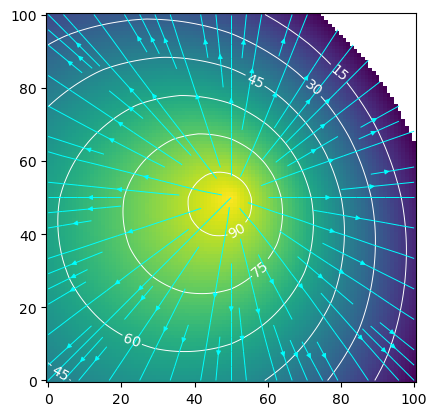

In [50]:
fig,ax=plt.subplots()
X,Y=np.meshgrid(h*np.arange(W),h*np.arange(H))
pc2=ax.pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)
ax.clabel(CS, inline=True, fontsize=10)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.84,color='aqua',linewidth=0.7,arrowsize=0.7)
ax.set_aspect('equal')



In [51]:
#finding the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,h,h,velocity_func=lambda a: glide_ratio(a,wind))
true_grid=np.inf*np.ones([H,W])
true_grid_chars=np.zeros([H,W,2])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
    true_grid_chars[pos]=init_chars[i]

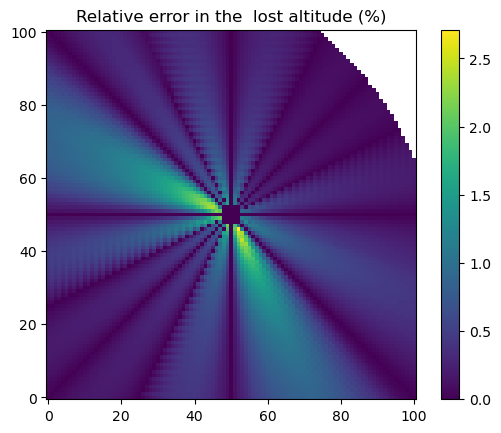

In [52]:
fig,ax=plt.subplots()
X,Y=np.meshgrid(h*np.arange(W),h*np.arange(H))
grid_lost_altitude=init_altitude-grid
true_grid_lost_altitude=init_altitude-true_grid
rel_error=np.abs(grid_lost_altitude-true_grid_lost_altitude)/(true_grid_lost_altitude+1e-10)

im=ax.pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
ax.set_aspect('equal')
fig.colorbar(im,ax=ax)
ax.title.set_text('Relative error in the  lost altitude (%)')